In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np

import time

In [2]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    # Use c = y to color each point
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    #plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)
    
def plot_model2(X, y, model, r2 = 5, step = 10):
    """
    Plot the subdomain partition predicted by the neuaral network
    """
    model.cpu()
    mesh = np.arange(-r2 -0.5, r2 + 0.5, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    # Plot the sample points of each subdomain
    # plt.scatter(X.numpy()[:-1:step, 0], X.numpy()[:-1:step, 1], c=y[:-1:step], s=20, cmap=plt.cm.Spectral)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plt.ylabel('$x_2$')
    plt.xlabel('$x_1$')
    plt.title('Predicted domain partiton')

In [3]:
set_default()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\abhil\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

# Input parameters.
N = 500  # number of sample points in each subdomain D_i
D = 2  # dimensions
C = 4  # number of sub-classes
H1 = 20  # number of neuros of the first hidden layer
H2 = 10  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer
H4 = 10 # number of neuros of the fourth hidden layer
noice = 0.2 # noice rate

# Allocation of the memories 
#  X: a 2D array for the matrix of order NC x D
#  y: a 1D array for the vector of order NC
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

# Generate a uniform partition of interval [0, 1] for parameter variable t
#  t_j = j/N for j=0, 1, 2, ..., N
t = torch.linspace(0, 1, N)

# Length of each subinterval 
tau = 2 * math.pi / C

In [5]:
for i in range(C):  # Here i = 0, 1, 2, ..., C-1
    j = 0
    # Generate N numbers in the subinterval [tau*i, tau*(i+1)] with tau = 2pi/C
    theta = torch.linspace(tau * i, tau * (i + 1), N) + torch.randn(N) * noice
    # Generate the N sample points in the $i$th subdomain D_i
    for ix in range(N * i, N * (i + 1)):
        X[ix] = t[j] * torch.FloatTensor((
            math.sin(theta[j]), math.cos(theta[j])
        ))
        y[ix] = i
        j += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))
#print('y=', y)
#print('X=', X)

Shapes:
X: (2000, 2)
y: (2000,)


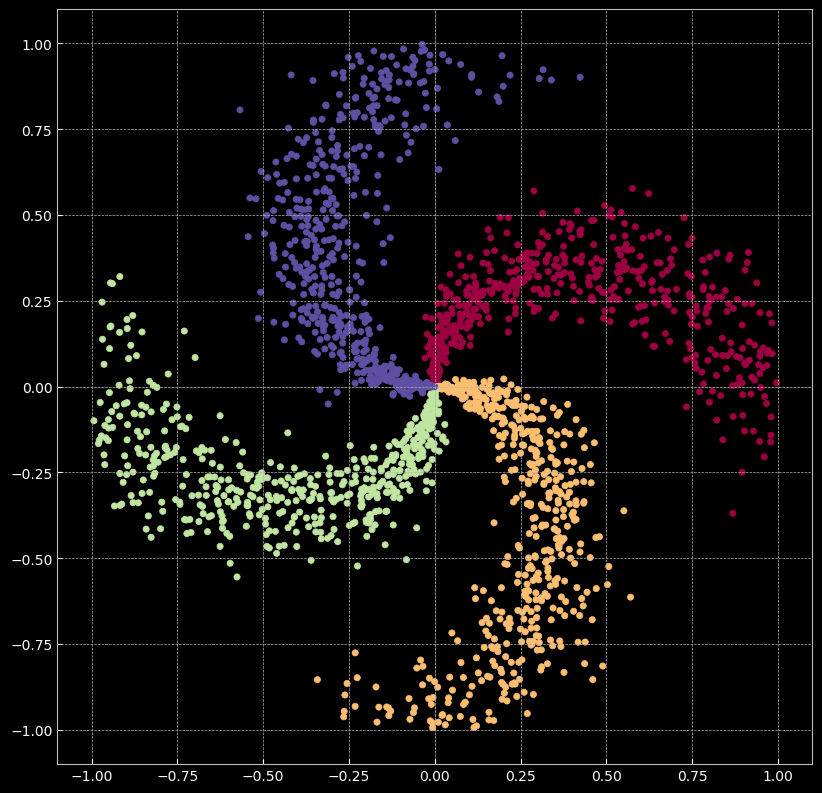

In [6]:
plot_data(X, y)